<a href="https://colab.research.google.com/github/suann124/AIinTeaching_Archive/blob/main/lectures/Introduction/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## The stick experiment

<div style="text-align:center">
  <img src="https://raw.githubusercontent.com/utopcu-asg/AIinTeaching/main/lectures/Introduction/images/stick_experiment.png"
       width="500">
</div>

![](https://raw.githubusercontent.com/utopcu-asg/AIinTeaching/main/lectures/Introduction/images/open_closed_loop.png)



### An illustrative example: aircraft pitch control

To introduce the central ideas of **stability**, **performance**, and **robustness** in feedback control,
we consider a simple model of an aircraft’s pitch motion.

The figure below is a *conceptual cartoon* of the pitch dynamics.
It is not intended to represent a full aerodynamic model.
Instead, it highlights the essential cause–effect relationships that feedback control is designed to manage.

<div style="text-align:center">
  <img src="https://raw.githubusercontent.com/utopcu-asg/AIinTeaching/main/lectures/Introduction/images/pitchmodel.png"
       width="800">
</div>


- The aircraft’s **pitch angle** $\theta$ describes its orientation.
- The controller applies a **pitch control moment** $u$ through the elevator.
- External effects such as wind gusts introduce an unknown **disturbance moment** $d$.
- Sensors measure the aircraft motion and provide feedback to the controller.

This cartoon already captures the three key ingredients of feedback control:
a dynamical system (the aircraft), an actuator (the elevator),
and uncertainty/disturbances (gusts).


We describe the aircraft’s pitch motion using a simple linearized model.
Define the state variables
$$
\theta = \text{pitch angle}, \qquad q = \dot{\theta} = \text{pitch rate}.
$$

The dynamics are modeled as
$$
\begin{aligned}
\dot{\theta}(t) &= q(t), \\
\dot{q}(t) &= a\,q(t) + b\,\theta(t) + c\,u(t) + d(t),
\end{aligned}
$$
where:
- $a$ represents aerodynamic damping,
- $b$ represents pitch stiffness (which may be destabilizing),
- $c$ represents control effectiveness,
- $u$ is the **pitch control moment** commanded by the controller,
- $d$ is an external **disturbance moment** due to gusts.

In state-space form,
$$
x = \begin{bmatrix} \theta \\ q \end{bmatrix}, \qquad
\dot{x} =
\begin{bmatrix}
0 & 1 \\
b & a
\end{bmatrix} x
+
\begin{bmatrix}
0 \\
c
\end{bmatrix} u
+
\begin{bmatrix}
0 \\
1
\end{bmatrix} d.
$$

- Stability  
If the aircraft is perturbed (for example, by a gust), does it naturally return
to its nominal attitude, or does the motion grow without bound?
Feedback can stabilize dynamics that would otherwise drift or diverge.

- Performance  
Even when the aircraft is stable, how *well* does it respond?
Does it return slowly or quickly?
Does it overshoot or oscillate?
Different feedback designs can shape the transient behavior in very different ways.

- Robustness  
The controller is designed using an approximate model of the aircraft.
In reality, parameters such as aerodynamic damping, control effectiveness,
and disturbance strength are uncertain.
A robust feedback controller continues to perform acceptably
even when the model is imperfect and disturbances are present.

In what follows, we use a simple mathematical model of the aircraft’s pitch motion
and simulate its behavior under different control strategies.
The goal is not to capture all aspects of flight dynamics,
but to *visually demonstrate* how feedback influences stability,
performance, and robustness before developing the formal theory.

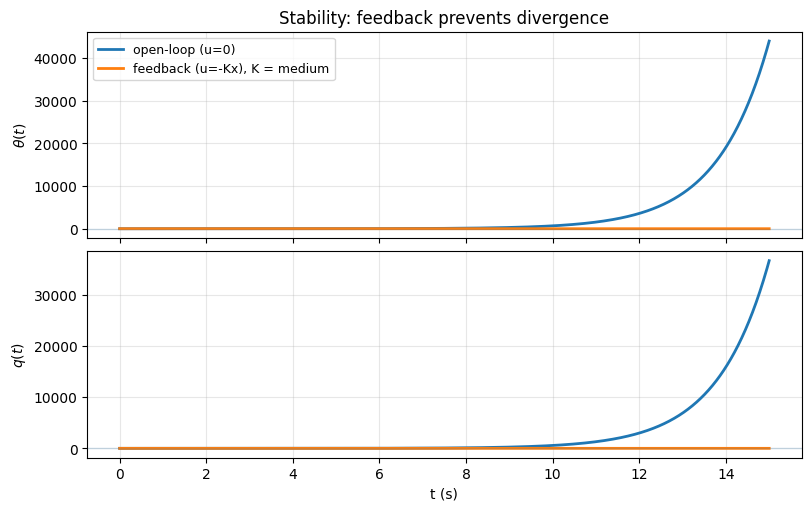

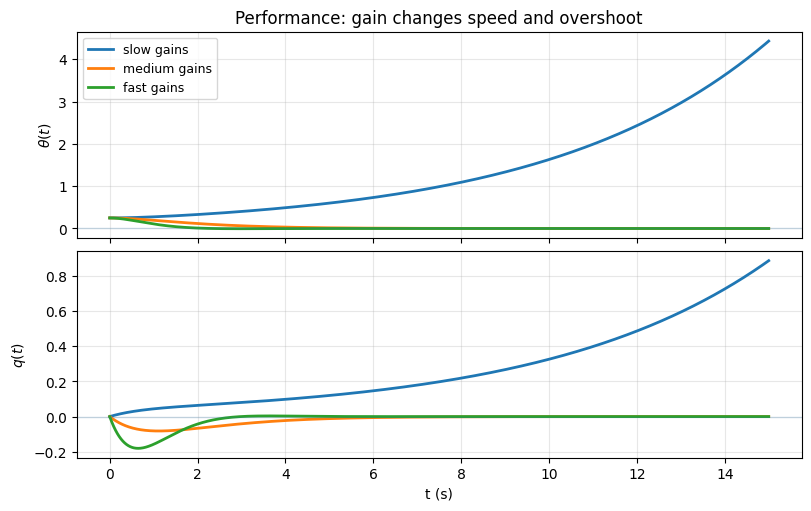

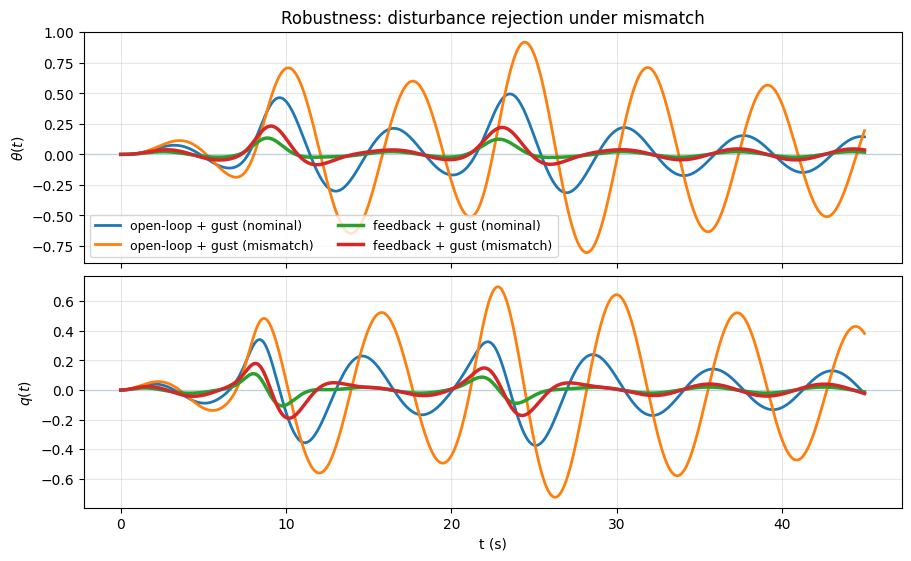

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ============================================================
# SIMPLE PITCH MODEL (2 states)
#   x = [theta, q]^T
#   theta_dot = q
#   q_dot     = a*q + b*theta + c*u + d(t)
#
# Open-loop: u(t) = 0
# Feedback:  u(t) = -K x(t)
#
# We use TWO DIFFERENT PLANTS:
#   - Plant S (stability/performance): intentionally unstable open-loop
#   - Plant R (robustness): open-loop stable, but poor disturbance rejection
# ============================================================

# ----------------------------
# Gust disturbance (bounded)
# ----------------------------
def gust(t):
    return (0.35*np.exp(-((t-8.0)/0.9)**2) +
            0.30*np.exp(-((t-22.0)/1.2)**2) +
            0.06*np.sin(0.9*t))

# ----------------------------
# Simulation of xdot = A x + B u + [0; d(t)]
# ----------------------------
def simulate(a, b, c, K=None, t_end=30.0, x0=(0.25, 0.0), umax=5.0, use_gust=False):
    A = np.array([[0.0, 1.0],
                  [b,   a]])
    B = np.array([[0.0],
                  [c]])

    x0 = np.array(x0, dtype=float)
    t_eval = np.linspace(0.0, t_end, 1800)

    def u_of_x(x):
        if K is None:
            u = 0.0
        else:
            u = -float(K @ x)
        return float(np.clip(u, -umax, umax))

    def f(t, x):
        u = u_of_x(x)
        d = gust(t) if use_gust else 0.0
        return (A @ x + (B.flatten() * u) + np.array([0.0, d]))

    sol = solve_ivp(f, (0.0, t_end), x0, t_eval=t_eval, rtol=1e-7, atol=1e-9)
    X = sol.y
    U = np.array([u_of_x(X[:, i]) for i in range(X.shape[1])])
    return sol.t, X, U

def plot_theta_q(t, X, axs, label=None, lw=2):
    axs[0].plot(t, X[0, :], lw=lw, label=label)
    axs[1].plot(t, X[1, :], lw=lw, label=label)

# ============================================================
# (A) PLANT S: intentionally unstable open-loop (for stability + performance)
# Choose b > 0 so open-loop tends to diverge (motivates feedback).
# ============================================================
a_S = -0.6
b_S = +1.2
c_S =  1.0

# Controllers for Plant S
K_slow   = np.array([0.9, 0.7])
K_medium = np.array([2.0, 1.2])
K_fast   = np.array([4.0, 2.0])

# (1) STABILITY (Plant S, no gust)
t_st_ol, X_st_ol, _ = simulate(a_S, b_S, c_S, K=None,     t_end=15.0, x0=(0.25, 0.0), use_gust=False)
t_st_cl, X_st_cl, _ = simulate(a_S, b_S, c_S, K=K_medium, t_end=15.0, x0=(0.25, 0.0), use_gust=False)

# (2) PERFORMANCE (Plant S, no gust)
t_pf, X_pf_s, _ = simulate(a_S, b_S, c_S, K=K_slow,   t_end=15.0, x0=(0.25, 0.0), use_gust=False)
t_pf, X_pf_m, _ = simulate(a_S, b_S, c_S, K=K_medium, t_end=15.0, x0=(0.25, 0.0), use_gust=False)
t_pf, X_pf_f, _ = simulate(a_S, b_S, c_S, K=K_fast,   t_end=15.0, x0=(0.25, 0.0), use_gust=False)

# ============================================================
# (B) PLANT R: open-loop stable but poor disturbance rejection (for robustness)
# Choose a < 0 and b < 0 to make open-loop stable.
# Then add gusts and compare open-loop vs feedback,
# under nominal and mismatched parameters.
# ============================================================
a_R_nom = -0.4
b_R_nom = -1.0
c_R_nom =  1.0

# Mismatch: still stable open-loop, but less damping + weaker actuator
a_R_mis = -0.15
b_R_mis = -0.7
c_R_mis =  0.6

# Use one fixed controller for robustness comparisons
K_R = np.array([2.0, 1.2])
umax_R = 3.0
Trob = 45.0

# Robustness simulations (Plant R, with gust)
t_r1, X_r_ol_nom, _ = simulate(a_R_nom, b_R_nom, c_R_nom, K=None,  t_end=Trob, x0=(0.0, 0.0), umax=umax_R, use_gust=True)
t_r2, X_r_ol_mis, _ = simulate(a_R_mis, b_R_mis, c_R_mis, K=None,  t_end=Trob, x0=(0.0, 0.0), umax=umax_R, use_gust=True)

t_r3, X_r_cl_nom, _ = simulate(a_R_nom, b_R_nom, c_R_nom, K=K_R,   t_end=Trob, x0=(0.0, 0.0), umax=umax_R, use_gust=True)
t_r4, X_r_cl_mis, _ = simulate(a_R_mis, b_R_mis, c_R_mis, K=K_R,   t_end=Trob, x0=(0.0, 0.0), umax=umax_R, use_gust=True)

# ============================================================
# PLOTS
# ============================================================

# ----------------------------
# Figure 1: Stability (Plant S)
# ----------------------------
fig1, axs1 = plt.subplots(2, 1, figsize=(8, 5), sharex=True, constrained_layout=True)
plot_theta_q(t_st_ol, X_st_ol, axs1, label="open-loop (u=0)")
plot_theta_q(t_st_cl, X_st_cl, axs1, label="feedback (u=-Kx), K = medium")
axs1[0].set_title("Stability: feedback prevents divergence")
axs1[0].set_ylabel(r"$\theta(t)$")
axs1[1].set_ylabel(r"$q(t)$")
axs1[1].set_xlabel("t (s)")
for ax in axs1:
    ax.grid(alpha=0.3)
    ax.axhline(0, lw=1, alpha=0.2)
axs1[0].legend(fontsize=9)
plt.show()

# ----------------------------
# Figure 2: Performance (Plant S)
# ----------------------------
fig2, axs2 = plt.subplots(2, 1, figsize=(8, 5), sharex=True, constrained_layout=True)
plot_theta_q(t_pf, X_pf_s, axs2, label="slow gains")
plot_theta_q(t_pf, X_pf_m, axs2, label="medium gains")
plot_theta_q(t_pf, X_pf_f, axs2, label="fast gains")
axs2[0].set_title("Performance: gain changes speed and overshoot")
axs2[0].set_ylabel(r"$\theta(t)$")
axs2[1].set_ylabel(r"$q(t)$")
axs2[1].set_xlabel("t (s)")
for ax in axs2:
    ax.grid(alpha=0.3)
    ax.axhline(0, lw=1, alpha=0.2)
axs2[0].legend(fontsize=9)
plt.show()

# ----------------------------
# Figure 3: Robustness (Plant R)
# Message: open-loop is stable, but does not reject gusts well, mismatch makes it worse.
# Feedback rejects gusts well, and still works under mismatch.
# ----------------------------
fig3, axs3 = plt.subplots(2, 1, figsize=(9, 5.5), sharex=True, constrained_layout=True)

plot_theta_q(t_r1, X_r_ol_nom, axs3, label="open-loop + gust (nominal)", lw=2)
plot_theta_q(t_r2, X_r_ol_mis, axs3, label="open-loop + gust (mismatch)", lw=2)

plot_theta_q(t_r3, X_r_cl_nom, axs3, label="feedback + gust (nominal)", lw=2.5)
plot_theta_q(t_r4, X_r_cl_mis, axs3, label="feedback + gust (mismatch)", lw=2.5)

axs3[0].set_title("Robustness: disturbance rejection under mismatch")
axs3[0].set_ylabel(r"$\theta(t)$")
axs3[1].set_ylabel(r"$q(t)$")
axs3[1].set_xlabel("t (s)")
for ax in axs3:
    ax.grid(alpha=0.3)
    ax.axhline(0, lw=1, alpha=0.2)

axs3[0].legend(fontsize=9, ncol=2)
plt.show()


### Feedback is everywhere

Feedback control is a unifying idea that appears across engineering, science,
technology, and society. Whenever a system must behave reliably in the presence
of uncertainty, disturbances, or changing conditions, feedback plays a central role.

Below are representative examples across many domains.


### Everyday and classical engineering systems

- **Thermostats**  
  Measure temperature and adjust heating or cooling to maintain a setpoint.

- **Cruise control in cars**  
  Measure vehicle speed and adjust engine power to reject hills and wind.

- **Audio systems**  
  Microphone–speaker feedback can stabilize amplification or cause oscillations
  (feedback squeal) if poorly designed.

- **Manufacturing and industrial automation**  
  Use feedback to achieve precision, regulate quality, and adapt to variability
  in materials and operating conditions.



### Vehicles, robotics, and autonomous systems

- **Aircraft and spacecraft**  
  Use feedback to stabilize inherently unstable dynamics and reject disturbances
  such as wind gusts or environmental uncertainty.

- **Drones and aerial robots**  
  Are open-loop unstable and rely entirely on high-rate feedback to fly.

- **Robotics**  
  Use sensor feedback to maintain balance, track trajectories, and interact safely
  with uncertain environments.

- **Autonomous vehicles**  
  Use feedback to regulate speed, steering, and spacing under changing road and
  traffic conditions.


### Computing, communication, and information systems

- **Computer networks and the internet**  
  Use feedback to manage congestion, allocate bandwidth, and maintain stability.

- **Cloud computing and data centers**  
  Adjust resources in real time based on performance measurements such as latency
  and load.

- **Smartphone cameras and consumer electronics**  
  Continuously adjust focus, exposure, and stabilization using sensor feedback.

### Learning, intelligence, and decision-making systems

- **Machine learning and AI**  
  Use error or reward feedback to update models and improve performance over time.

- **Reinforcement learning**  
  Is explicitly built around feedback from the environment.

- **Human learning and education**  
  Rely on feedback from outcomes, grades, and corrections to guide improvement.


### Biological, medical, and ecological systems

- **Human balance and motor control**  
  Use sensory feedback to stabilize posture and coordinate motion.

- **Physiological regulation**  
  Body temperature, glucose levels, and hormone regulation are controlled via
  feedback loops.

- **Medical devices**  
  Insulin pumps, pacemakers, and anesthesia systems use feedback to ensure safety.

- **Ecosystems and population dynamics**  
  Predator–prey relationships and resource availability form natural feedback loops.



### Social, economic, and large-scale systems

- **Power grids and energy systems**  
  Use feedback to regulate frequency, voltage, and balance supply and demand.

- **Supply chains and logistics**  
  Adjust production and inventory based on demand feedback; delays can cause
  instability (the bullwhip effect).

- **Financial markets and automated trading**  
  Prices respond to actions, and actions respond to prices, forming tight feedback loops.

- **Economic and policy systems**  
  Central banks adjust interest rates based on measured economic indicators.


### Fluid, thermal, and propulsion systems


- **Aerodynamic flow control**  
  Measure pressure or velocity and adjust actuators to suppress flow separation
  and reduce unsteady aerodynamic loads.

- **Jet and rocket engines**  
  Measure chamber pressure or thrust and adjust fuel flow to regulate performance
  and prevent combustion instabilities.

- **Thermal management systems**  
  Measure temperature and adjust cooling or heating to protect engines,
  avionics, and thermal protection systems.

- **Propellant and fuel systems**  
  Measure pressure and flow rate and adjust valves to maintain safe
  and reliable operation under changing conditions.


### Less obvious (maybe?) feedback systems


- **Noise-canceling headphones**  
  Measure ambient sound and generate an equal-and-opposite signal
  to cancel noise in real time.

- **Anti-lock braking systems (ABS)**  
  Measure wheel slip and rapidly modulate braking force
  to prevent loss of traction.

- **Image stabilization (cameras and phones)**  
  Measure hand motion and adjust sensors or optics
  to reduce blur during exposure.

- **Space telescopes and precision optics**  
  Measure tiny structural deformations and adjust actuators
  to maintain alignment at extremely small scales.

- **Internet congestion control (e.g., TCP)**  
  Measure packet loss and delay and adjust transmission rates
  to avoid network collapse.

- **Recommendation and social-media systems**  
  Measure user engagement and adapt content delivery,
  forming feedback loops between users and algorithms.

- **Anesthesia delivery systems**  
  Measure patient response and adjust drug dosage
  to maintain safe levels of sedation.


## Representations of dynamical system models

A key idea in feedback control is that **the same dynamical system can be represented
in multiple, mathematically equivalent forms**.
Each representation emphasizes different aspects of the system and is useful
for answering different questions.

In this course, we will primarily use four representations:
1. Ordinary differential equations (ODEs)
2. State-space models
3. Transfer functions
4. Block diagrams

We illustrate each representation using the same example: a **DC motor**.

---

### Example: DC motor dynamics

The DC motor consists of a mechanical subsystem (rotation of the motor shaft)
and an electrical subsystem (armature circuit). The input is the armature voltage $v_a$.

---

## (1) ODE representation

Starting from Newton’s law and the armature circuit, we can write the DC motor model
directly as coupled ordinary differential equations. In the form shown in the notes:

**Mechanical dynamics (second order):**
$$
J_m \ddot{\theta}_m + b\,\dot{\theta}_m = k_t i_a.
$$

**Electrical dynamics (first order):**
$$
L_a \frac{d i_a}{dt} + R_a i_a = v_a - k_e \dot{\theta}_m.
$$

This representation is closest to the underlying physics and is often how models
are first written down.

---

## (2) State-space representation

To obtain a state-space model, we choose state variables
$$
x =
\begin{bmatrix}
\theta_m\\
\dot{\theta}_m\\
i_a
\end{bmatrix},
\qquad
u = v_a.
$$

The state-space model has the standard form
$$
\dot{x} = A x + B u,
\qquad
y = Cx + Du,
$$
and for this example (as in the notes),
$$
\dot{x} =
\begin{bmatrix}
0 & 1 & 0 \\
0 & -\frac{b}{J_m} & \frac{k_t}{J_m} \\
0 & -\frac{k_e}{L_a} & -\frac{R_a}{L_a}
\end{bmatrix}x
+
\begin{bmatrix}
0\\
0\\
\frac{1}{L_a}
\end{bmatrix}v_a.
$$

Depending on what we choose to measure, the output equation may be, for example:
- position output: $y = \theta_m$,
- speed output: $y = \dot{\theta}_m$,
- current output: $y = i_a$,
or any combination of these.

---

## (3) Transfer function representation

If we focus on input–output behavior (and assume zero initial conditions),
we can represent the motor using a transfer function.

For example, the transfer function from armature voltage to motor angle is
$$
G(s) \;=\; \frac{\Theta_m(s)}{V_a(s)}
\;=\;
\frac{k_t}
{L_a J_m s^3 + (L_a b + R_a J_m)s^2 + (R_a b + k_t k_e)s}.
$$

Equivalently, the transfer function from armature voltage to motor speed
$\Omega_m(s)=s\Theta_m(s)$ is
$$
\frac{\Omega_m(s)}{V_a(s)}
=
\frac{k_t}
{(L_a s + R_a)(J_m s + b) + k_t k_e}.
$$

---

## (4) Block diagram representation

A block diagram provides a **graphical representation** of the model,
showing how signals flow between subsystems and how feedback interconnections
are formed.

For the DC motor, a natural block diagram view separates:
- the electrical subsystem (voltage $\to$ current),
- the mechanical subsystem (current $\to$ torque $\to$ speed/position),
- the feedback effect of back-emf (speed feeding back into the circuit equation).

---

### Choosing a representation

All four representations describe the **same underlying dynamical system**.
The choice of representation depends on the question being asked:

- ODEs emphasize **physical modeling**
- State-space models emphasize **dynamics and internal state**
- Transfer functions emphasize **input–output behavior**
- Block diagrams emphasize **interconnections and feedback structure**

A central theme of this course is learning how to move fluently
between these representations and use each one effectively
for analysis and control design.